<a href="https://colab.research.google.com/github/Bernardomeirelles/modleo_recomendacao/blob/main/Modelo_de_Recomenda%C3%A7%C3%A3o__Completasso_com_CrossValidation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Notebook para Classificação Binária de Reviews da B2W

Este notebook implementa uma rede neural usando Keras/TensorFlow para classificar se uma review do dataset `B2W-Reviews01.csv` recomenda ou não um produto a um amigo.

**Instruções seguidas:**
1. Utiliza a coluna `recommend_to_a_friend`.
2. Utiliza `review_text` como texto de entrada.
3. Divisão treino/teste 80/20.
4. Implementa validação cruzada (K-Fold).
5. Exporta o modelo treinado (`.keras`).
6. Cria uma função para predição de novos dados.
7. Preparado para execução no Google Colab.

In [57]:
# 1. Instalação de Dependências
# Descomente e execute a célula abaixo se estiver no Google Colab ou em um ambiente sem as bibliotecas instaladas.
# !pip install tensorflow pandas scikit-learn

# 2. Importar Bibliotecas

In [93]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras # Importar keras de tensorflow
from tensorflow.keras.layers import Embedding, GlobalAveragePooling1D, Dense, TextVectorization
from tensorflow.keras.models import Sequential
from tensorflow.keras import utils # Importar utils para o decorador
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
import re
import string

# 3. Carregar e Preparar os Dados

In [95]:
# Carregar o dataset
# Certifique-se de que o arquivo B2W-Reviews01.csv está no mesmo diretório ou forneça o caminho correto.
# No Google Colab, você precisará fazer o upload do arquivo.
csv_path = 'B2W-Reviews01.csv'
try:
    df = pd.read_csv(csv_path)
    print(f"Dataset '{csv_path}' carregado com sucesso.")
except FileNotFoundError:
    print(f"Erro: Arquivo '{csv_path}' não encontrado. Faça o upload para o ambiente do Colab.")
    # Você pode adicionar um comando para parar a execução aqui se desejar
    # raise

if 'df' in locals(): # Prosseguir apenas se o df foi carregado
    # Selecionar colunas relevantes e tratar valores ausentes
    df = df[['review_text', 'recommend_to_a_friend']].copy()
    df.dropna(subset=['review_text', 'recommend_to_a_friend'], inplace=True)

    # Criar a variável target binária (1 para 'Yes', 0 para 'No')
    df['target'] = df['recommend_to_a_friend'].apply(lambda x: 1 if x == 'Yes' else 0)

    # Exibir informações básicas e distribuição da classe
    print(f"Total de amostras após limpeza: {len(df)}")
    print("Distribuição da classe target (0 = Não Recomenda, 1 = Recomenda):")
    print(df['target'].value_counts(normalize=True))

    # Definir X e y
    X = df['review_text'].astype(str) # Garantir que é string
    y = df['target'].values

<ipython-input-95-75aafc1405b4>:6: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(csv_path)


Dataset 'B2W-Reviews01.csv' carregado com sucesso.
Total de amostras após limpeza: 129080
Distribuição da classe target (0 = Não Recomenda, 1 = Recomenda):
target
1    0.736489
0    0.263511
Name: proportion, dtype: float64


# 4. Dividir Dados em Treino e Teste (80/20)

In [97]:
if 'X' in locals(): # Prosseguir apenas se X e y existem
    X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

    print(f"Tamanho do conjunto de treino completo: {len(X_train_full)}")
    print(f"Tamanho do conjunto de teste: {len(X_test)}")
else:
    print("Erro: Variáveis X e y não definidas. Verifique o carregamento dos dados.")

Tamanho do conjunto de treino completo: 103264
Tamanho do conjunto de teste: 25816


# 5. Pré-processamento de Texto com TextVectorization

In [104]:


@utils.register_keras_serializable()
def custom_standardization(input_data):
    lowercase = tf.strings.lower(input_data)
    stripped_html = tf.strings.regex_replace(lowercase, "<br />", " ")
    return tf.strings.regex_replace(stripped_html,
                                  "[%s]" % re.escape(string.punctuation),
                                  "")

if 'X_train_full' in locals(): # Prosseguir apenas se os dados de treino existem
    # Definir parâmetros para TextVectorization
    max_features = 10000  # Número máximo de palavras no vocabulário
    sequence_length = 250 # Comprimento máximo das sequências

    # Instanciar a camada TextVectorization
    # Usando a função custom_standardization registrada
    vectorize_layer = TextVectorization(
        standardize=custom_standardization, # Usa a função registrada
        max_tokens=max_features,
        output_mode='int',
        output_sequence_length=sequence_length)
  # Adaptar a camada TextVectorization APENAS com os dados de treino
    print("Adaptando a camada TextVectorization (aprendendo o vocabulário)...")
    vectorize_layer.adapt(X_train_full.values)
    print("Adaptação concluída.")

else:
    print("Erro: Conjunto de treino (X_train_full) não definido. Verifique a divisão dos dados.")

Adaptando a camada TextVectorization (aprendendo o vocabulário)...
Adaptação concluída.


# 6. Construção do Modelo de Rede Neural

In [105]:
embedding_dim = 16

def create_model():
    # A camada vectorize_layer definida e adaptada na célula anterior
    # é incluída como a primeira camada do modelo.
    model = Sequential([
        vectorize_layer, # Camada de vetorização JÁ ADAPTADA
        Embedding(max_features + 1, embedding_dim),
        GlobalAveragePooling1D(),
        Dense(16, activation='relu'),
        Dense(1, activation='sigmoid') # Saída binária
    ])

    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

# Criar uma instância para ver o sumário (opcional)
if 'vectorize_layer' in locals():
    model_summary = create_model()
    print( "--- Arquitetura do Modelo ---")
    model_summary.summary()
else:
    print("Erro: Camada de vetorização não definida. Verifique o pré-processamento.")

--- Arquitetura do Modelo ---


Model: "sequential_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ text_vectorization_4            │ ?                      │   0 (unbuilt) │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_17 (Embedding)        │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_17     │ ?                      │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_34 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_35 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

# 7. Treinamento com Validação Cruzada (Stratified K-Fold)

In [106]:
if 'X_train_full' in locals() and 'vectorize_layer' in locals(): # Checar dependências
    n_splits = 5 # Número de folds para validação cruzada
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

    fold_accuracies = []
    fold_histories = []

    print(f"Iniciando treinamento com validação cruzada ({n_splits} folds)...")

    fold_no = 1
    for train_index, val_index in skf.split(X_train_full, y_train_full):
        print(f"--- Fold {fold_no}/{n_splits} ---")

        # Dividir dados do fold
        X_train_fold = X_train_full.iloc[train_index]
        y_train_fold = y_train_full[train_index]
        X_val_fold = X_train_full.iloc[val_index]
        y_val_fold = y_train_full[val_index]

        # Criar datasets do TensorFlow para o fold atual (com texto bruto)
        train_fold_ds = tf.data.Dataset.from_tensor_slices((X_train_fold.values, y_train_fold))
        train_fold_ds = train_fold_ds.batch(32).prefetch(tf.data.AUTOTUNE)

        val_fold_ds = tf.data.Dataset.from_tensor_slices((X_val_fold.values, y_val_fold))
        val_fold_ds = val_fold_ds.batch(32).prefetch(tf.data.AUTOTUNE)

        # Criar e compilar o modelo (uma nova instância para cada fold)
        model_fold = create_model()

        # Treinar o modelo (passando texto bruto)
        epochs = 5 # Número de épocas por fold (ajuste conforme necessário)
        print(f"Treinando Fold {fold_no} por {epochs} épocas...")
        history = model_fold.fit(
            train_fold_ds, # Passa texto bruto
            validation_data=val_fold_ds, # Passa texto bruto
            epochs=epochs,
            verbose=1 # Mostrar progresso
        )

        # Avaliar no conjunto de validação do fold
        loss, accuracy = model_fold.evaluate(val_fold_ds, verbose=0)
        print(f"-> Acurácia de validação do Fold {fold_no}: {accuracy:.4f}")
        fold_accuracies.append(accuracy)
        fold_histories.append(history)

        fold_no += 1

    # --- Output Melhorado ---
    print("" + "="*40)
    print("Resultado da Validação Cruzada")
    print("="*40)
    mean_acc = np.mean(fold_accuracies)
    std_acc = np.std(fold_accuracies)
    print(f"Acurácia Média nos {n_splits} folds: {mean_acc:.4f}")
    print(f"Desvio Padrão da Acurácia: {std_acc:.4f}")
    print("Explicação:")
    print(f"- A acurácia média de {mean_acc:.2%} indica que, em média, o modelo acertou essa porcentagem das classificações nos testes de validação.")
    print("- O desvio padrão baixo sugere que a performance do modelo foi consistente entre os diferentes folds.")
    print("="*40)

else:
    print("Erro: Variáveis necessárias para validação cruzada não definidas.")

Iniciando treinamento com validação cruzada (5 folds)...
--- Fold 1/5 ---
Treinando Fold 1 por 5 épocas...
Epoch 1/5
2582/2582 ━━━━━━━━━━━━━━━━━━━━ 20s 7ms/step - accuracy: 0.7466 - loss: 0.5328 - val_accuracy: 0.8073 - val_loss: 0.3920
Epoch 2/5
2582/2582 ━━━━━━━━━━━━━━━━━━━━ 17s 6ms/step - accuracy: 0.8652 - loss: 0.3200 - val_accuracy: 0.8479 - val_loss: 0.3478
Epoch 3/5
2582/2582 ━━━━━━━━━━━━━━━━━━━━ 21s 7ms/step - accuracy: 0.8883 - loss: 0.2773 - val_accuracy: 0.8611 - val_loss: 0.3208
Epoch 4/5
2582/2582 ━━━━━━━━━━━━━━━━━━━━ 19s 6ms/step - accuracy: 0.8973 - loss: 0.2608 - val_accuracy: 0.8684 - val_loss: 0.3099
Epoch 5/5
2582/2582 ━━━━━━━━━━━━━━━━━━━━ 20s 6ms/step - accuracy: 0.9035 - loss: 0.2498 - val_accuracy: 0.8741 - val_loss: 0.3025
-> Acurácia de validação do Fold 1: 0.8741
--- Fold 2/5 ---
Treinando Fold 2 por 5 épocas...
Epoch 1/5
2582/2582 ━━━━━━━━━━━━━━━━━━━━ 19s 7ms/step - accuracy: 0.7606 - loss: 0.5089 - val_accuracy: 0.8519 - val_loss: 0.3216
Epoch 2/5
2582/2582 

# 8. Treinamento do Modelo Final (com todos os dados de treino)

In [107]:
if 'X_train_full' in locals() and 'vectorize_layer' in locals(): # Checar dependências
    print("Treinando modelo final com todos os dados de treino...")

    # Criar datasets completos de treino (com texto bruto)
    train_full_ds = tf.data.Dataset.from_tensor_slices((X_train_full.values, y_train_full))
    train_full_ds = train_full_ds.batch(32).prefetch(tf.data.AUTOTUNE)

    # Criar e treinar o modelo final
    final_model = create_model()
    final_epochs = 5 # Ajuste conforme a análise dos folds ou necessidade
    print(f"Treinando modelo final por {final_epochs} épocas...")
    history_final = final_model.fit(
        train_full_ds, # Passa texto bruto
        epochs=final_epochs,
        verbose=1
    )
    print("Treinamento final concluído.")
else:
    print("Erro: Variáveis necessárias para o treinamento final não definidas.")

Treinando modelo final com todos os dados de treino...
Treinando modelo final por 5 épocas...
Epoch 1/5
3227/3227 ━━━━━━━━━━━━━━━━━━━━ 20s 5ms/step - accuracy: 0.7741 - loss: 0.4828
Epoch 2/5
3227/3227 ━━━━━━━━━━━━━━━━━━━━ 18s 6ms/step - accuracy: 0.8836 - loss: 0.2893
Epoch 3/5
3227/3227 ━━━━━━━━━━━━━━━━━━━━ 19s 6ms/step - accuracy: 0.8970 - loss: 0.2680
Epoch 4/5
3227/3227 ━━━━━━━━━━━━━━━━━━━━ 27s 8ms/step - accuracy: 0.9027 - loss: 0.2575
Epoch 5/5
3227/3227 ━━━━━━━━━━━━━━━━━━━━ 39s 7ms/step - accuracy: 0.9059 - loss: 0.2507
Treinamento final concluído.


# 9. Avaliação Final no Conjunto de Teste

Avaliando modelo final no conjunto de teste...
Resultados da Avaliação Final
-> Loss (Perda) no Teste: 0.2936
-> Acurácia no Teste: 0.8830 (88.30%)
Explicação:
- Loss: Uma medida do erro do modelo. Quanto menor, melhor.
- Acurácia: A porcentagem de classificações corretas (88.30%) que o modelo fez no conjunto de teste.
----------------------------------------
Gerando predições para o relatório detalhado...
807/807 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step
--- Relatório de Classificação Detalhado ---
                   precision    recall  f1-score   support

Não Recomenda (0)       0.72      0.92      0.81      6803
    Recomenda (1)       0.97      0.87      0.92     19013

         accuracy                           0.88     25816
        macro avg       0.84      0.90      0.86     25816
     weighted avg       0.90      0.88      0.89     25816

Explicação do Relatório:
- Precisão (Precision): Das vezes que o modelo previu uma classe, quantas ele acertou? (Ex: Precisão alta para 'Recomenda'

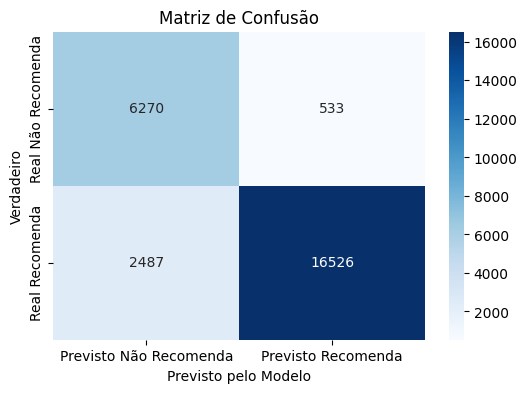

Explicação da Matriz:
- Diagonal Principal (azul mais escuro): Acertos do modelo (Verdadeiros Negativos e Verdadeiros Positivos).
- Fora da Diagonal (azul mais claro): Erros do modelo (Falsos Positivos e Falsos Negativos).
  - Falso Positivo: Modelo previu 'Recomenda', mas era 'Não Recomenda'.
  - Falso Negativo: Modelo previu 'Não Recomenda', mas era 'Recomenda'.


In [108]:
if 'final_model' in locals() and 'X_test' in locals() and 'y_test' in locals(): # Checar dependências
    print("Avaliando modelo final no conjunto de teste...")

    # Avaliar usando X_test.values e y_test diretamente
    loss_test, accuracy_test = final_model.evaluate(X_test.values, y_test, batch_size=32, verbose=0)

    print("" + "="*40)
    print("Resultados da Avaliação Final")
    print("="*40)
    print(f"-> Loss (Perda) no Teste: {loss_test:.4f}")
    print(f"-> Acurácia no Teste: {accuracy_test:.4f} ({accuracy_test:.2%})")
    print("Explicação:")
    print(f"- Loss: Uma medida do erro do modelo. Quanto menor, melhor.")
    print(f"- Acurácia: A porcentagem de classificações corretas ({accuracy_test:.2%}) que o modelo fez no conjunto de teste.")
    print("-"*40)

    # Fazer predições para gerar o relatório e a matriz de confusão
    print("Gerando predições para o relatório detalhado...")
    y_pred_proba = final_model.predict(X_test.values, batch_size=32)
    y_pred = (y_pred_proba > 0.5).astype(int).flatten()

    print("--- Relatório de Classificação Detalhado ---")
    # Imprimir o relatório de classificação
    report = classification_report(y_test, y_pred, target_names=['Não Recomenda (0)', 'Recomenda (1)'])
    print(report)
    print("Explicação do Relatório:")
    print("- Precisão (Precision): Das vezes que o modelo previu uma classe, quantas ele acertou? (Ex: Precisão alta para 'Recomenda' significa que quando ele diz 'Recomenda', é provável que esteja certo).")
    print("- Revocação (Recall): De todas as instâncias reais de uma classe, quantas o modelo conseguiu encontrar? (Ex: Recall alto para 'Recomenda' significa que o modelo encontrou a maioria das reviews que realmente recomendam).")
    print("- F1-Score: Uma média harmônica entre precisão e revocação. Útil para comparar o desempenho geral entre as classes.")
    print("- Support: Quantas instâncias reais de cada classe existem no conjunto de teste.")
    print("-"*40)

    # --- Matriz de Confusão ---
    print("--- Matriz de Confusão ---")
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Previsto Não Recomenda', 'Previsto Recomenda'],
                yticklabels=['Real Não Recomenda', 'Real Recomenda'])
    plt.ylabel('Verdadeiro')
    plt.xlabel('Previsto pelo Modelo')
    plt.title('Matriz de Confusão')
    plt.show()
    print("Explicação da Matriz:")
    print("- Diagonal Principal (azul mais escuro): Acertos do modelo (Verdadeiros Negativos e Verdadeiros Positivos).")
    print("- Fora da Diagonal (azul mais claro): Erros do modelo (Falsos Positivos e Falsos Negativos).")
    print("  - Falso Positivo: Modelo previu 'Recomenda', mas era 'Não Recomenda'.")
    print("  - Falso Negativo: Modelo previu 'Não Recomenda', mas era 'Recomenda'.")
    print("="*40)

else:
    print("Erro: Modelo final ou dados de teste não definidos para avaliação.")

# 10. Salvar o Modelo Treinado

In [109]:
if 'final_model' in locals(): # Checar dependências
    # Salvar o modelo Keras completo (inclui arquitetura, pesos e a camada TextVectorization com a função registrada)
    model_save_path = 'modelosalvo.keras' # Nome atualizado v7.1
    final_model.save(model_save_path)
    print(f"Modelo Keras salvo em: {model_save_path}")
else:
    print("Erro: Modelo final não definido para salvar.")

Modelo Keras salvo em: modelosalvo.keras


# 11. Criar Função de Predição para Novos Dados

In [112]:
# É necessário definir a função novamente dentro do ambiente do notebook
# para que ela seja encontrada ao carregar o modelo com custom_objects.
@utils.register_keras_serializable()
def custom_standardization(input_data):
    lowercase = tf.strings.lower(input_data)
    stripped_html = tf.strings.regex_replace(lowercase, "<br />", " ")
    return tf.strings.regex_replace(stripped_html,
                                  "[%s]" % re.escape(string.punctuation),
                                  "")

def predict_new_review(text_input, model_path=	'b2w_recommendation_model_v7.1.keras'	): # Path atualizado v7.1
    """
    Carrega o modelo Keras treinado e faz uma predição para um novo texto.

    Args:
        text_input (str): A string contendo a review a ser classificada.
        model_path (str): O caminho para o arquivo .keras do modelo salvo.

    Returns:
        tuple: (predicted_class (int), probability (float))
               Retorna (None, None) se o modelo não puder ser carregado.
    """
    try:
        # Carregar o modelo, passando a função customizada
        loaded_model = keras.models.load_model(model_path, custom_objects={	'custom_standardization'	: custom_standardization})

        # Correção: Fazer a predição passando um Tensor do TensorFlow
        predictions = loaded_model.predict(tf.constant([text_input]), verbose=0)
        probability = predictions[0][0]
        predicted_class = 1 if probability > 0.5 else 0

        return predicted_class, probability

    except Exception as e:
        print(f"\n*** ERRO ao tentar usar o modelo: {e} ***")
        print(f"*** Verifique se o arquivo 	'{model_path}'	 existe e foi gerado pela célula anterior. ***")
        return None, None

print("Função predict_new_review definida.")


Função predict_new_review definida.


# 12. Exemplo de Uso da Função de Predição

In [113]:
# Modelo a ser usado pela função predict_new_review
model_file_to_test = 'modelosalvo.keras'

def run_prediction_example(review_text):
    print(f'Analisando Review: "{review_text}"')
    pred_class, pred_prob = predict_new_review(review_text, model_file_to_test)

    if pred_class is not None:
        resultado = 'Recomenda' if pred_class == 1 else 'Não Recomenda'
        # Output simplificado: Apenas a recomendação final
        print(f'--> Recomendação: {resultado}')
    # A mensagem de erro já é impressa pela função predict_new_review se algo der errado

# --- Exemplos ---
review_positiva = "Adorei o produto! Entrega super rápida e qualidade excelente. Recomendo muito!"
review_negativa = "Péssima experiência. O produto veio quebrado e o atendimento foi horrível. Não comprem."

run_prediction_example(review_positiva)
run_prediction_example(review_negativa)



Analisando Review: "Adorei o produto! Entrega super rápida e qualidade excelente. Recomendo muito!"
--> Recomendação: Recomenda
Analisando Review: "Péssima experiência. O produto veio quebrado e o atendimento foi horrível. Não comprem."
--> Recomendação: Não Recomenda


--- Fim do Notebook ---